Your function returned a count of 8850  cars and 9531  non-cars
of size:  (64, 64, 3)  and data type: float32


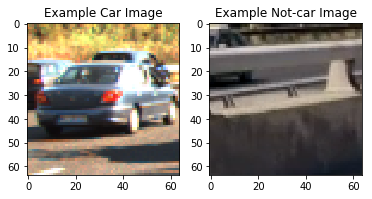

In [1]:
# import dataset and random show images of vehicles and non-vehicles
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

#PARAMETERS HERE
color_space = 'YCrCb'
hog_channel = 'ALL'
hist_bins = 16    # Number of histogram bins


cars = glob.glob('vehicles/*/*',recursive=True)
notcars = glob.glob('non-vehicles/*/*',recursive=True)

#print("cars[0]",cars[0])
           
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(str(cars[car_ind]))
notcar_image = mpimg.imread(str(notcars[notcar_ind]))


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

bin_spatial features shape: (3072,)


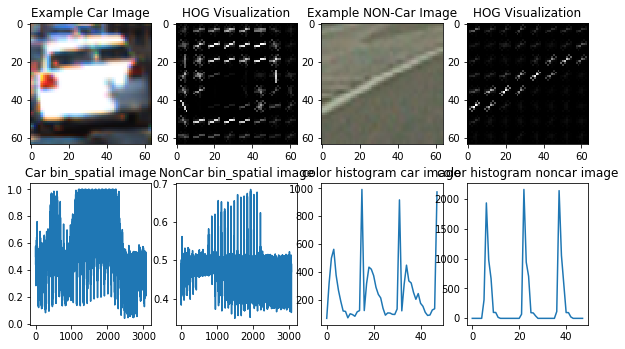

In [2]:
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True: # then no ALL channel available 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = hog(gray, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        if hog_channel == 'ALL':
            hog_features = []
            
            for channel in range(img.shape[2]):
                hog_features.extend(hog(img[:,:,channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec))      
        else:
            hog_features = hog(img[:,:,hog_channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
        #features = hog(img, orientations=orient, 
        #               pixels_per_cell=(pix_per_cell, pix_per_cell),
        #               cells_per_block=(cell_per_block, cell_per_block), 
        #               transform_sqrt=False, 
        #               visualise=vis, feature_vector=feature_vec)
        return hog_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     
    # Use cv2.resize().ravel() to create the feature vector
    small_img = cv2.resize(feature_image, size)
    features = small_img.ravel() 
    # Return the feature vector
    return features
    
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    
    
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(str(notcars[notcar_ind]))
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output

features, hog_image = get_hog_features(image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

feature_vec = bin_spatial(image, color_space=color_space, size=(32, 32))
feature_vec_noncar = bin_spatial(notcar_image,color_space=color_space, size=(32, 32))

color_his_feature_car = color_hist(image,nbins=hist_bins, bins_range=(0, 1))
color_his_feature_noncar = color_hist(notcar_image,nbins=hist_bins, bins_range=(0, 1))


print("bin_spatial features shape:",feature_vec.shape)

# Plot the examples
fig = plt.figure(figsize=(10, 12))
plt.subplot(441)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(442)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(443)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example NON-Car Image')
plt.subplot(444)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(445)
plt.plot(feature_vec)
plt.title('Car bin_spatial image')
plt.subplot(446)
plt.plot(feature_vec_noncar)
plt.title('NonCar bin_spatial image')
plt.subplot(447)
plt.plot(color_his_feature_car)
plt.title('color histogram car image')
plt.subplot(448)
plt.plot(color_his_feature_noncar)
plt.title('color histogram noncar image')

plt.show()

In [3]:
# First ,decide what features to use 
# combine color and gradient features
from sklearn.preprocessing import StandardScaler
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                bin_feature = bin_spatial(image, color_space='HSV', size=spatial_size)
            elif cspace == 'LUV':
                bin_feature = bin_spatial(image, color_space='LUV', size=spatial_size)
            elif cspace == 'HLS':
                bin_feature = bin_spatial(image, color_space='HLS', size=spatial_size)
            elif cspace == 'YUV':
                bin_feature = bin_spatial(image, color_space='YUV', size=spatial_size)
            elif cspace == 'YCrCb':
                bin_feature = bin_spatial(image, color_space='YCrCb', size=spatial_size)
        else:
            bin_feature = bin_spatial(image, color_space='RGB', size=spatial_size)  
        
        # Apply color_hist() to get color histogram features
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_feature = get_hog_features(image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)
        color_hist_feature = color_hist(image,nbins=hist_bins, bins_range=(0, 1))
        # Append the new feature vector to the features list
        combined_features = np.concatenate((bin_feature,hog_feature,color_hist_feature))
        features.append(combined_features)
    # Return list of feature vectors
    return features

car_features = extract_features(cars, cspace=color_space, spatial_size=(32, 32))
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=(32, 32))



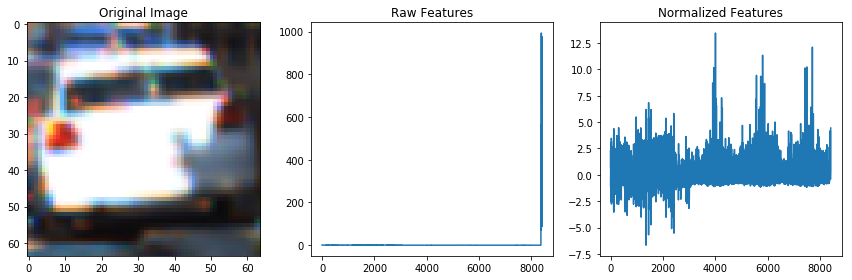

In [4]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

In [5]:
#Linear SVM Classifier
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm, grid_search, datasets
from sklearn.cross_validation import train_test_split
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# performs under different binning scenarios
spatial = 32
histbin = 32

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = SVC(kernel='rbf')
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1, 10,100]}
#svr = SVC()
#clf = grid_search.GridSearchCV(svr, parameters)
#svc.fit(iris.data, iris.target)
#svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
#clf.fit(X_train, y_train)
#print("best C:",clf.best_params_)
svc = svm.SVC(kernel='rbf',C=10)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8412
441.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9956
My SVC predicts:  [ 0.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
0.30952 Seconds to predict 10 labels with SVC


In [1]:
# fail on lesson 35 try lesson 34 
spatial_size=(32, 32)
y_start_stop = [350, 700] # Min and max in y to search in slide_window()
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    #print("shape of img:",img.shape)
    #print("x start stop:",x_start_stop)
    if(x_start_stop==[None,None]):
        x_start_stop = [0,img.shape[1]]
        #print("yeah")
        
    if(y_start_stop==[None,None]):
        y_start_stop = [0,img.shape[0]]
        #print("here")
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    x_step = float(xy_window[0])*float(xy_overlap[0])
    y_step = xy_window[1]*xy_overlap[1]
    #print("x_step:",x_step)
    #print("y_step:",y_step)
    # Compute the number of windows in x/y
    x_num_win = ((x_start_stop[1]-x_start_stop[0]-xy_window[0])/x_step)+1
    y_num_win = ((y_start_stop[1]-y_start_stop[0]-xy_window[1])/y_step)+1
    #print("x num win:",x_num_win)
    #print("y num win:",y_num_win) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for y in range(0,int(y_num_win)):
        #print("y:",y)
        y_start = int(y_start_stop[0]+y_step*y)
        y_stop = int(y_start_stop[0]+xy_window[1]+ y_step*y)
        for x in range(0,int(x_num_win)):
            #print("x:",x)
            x_start = int(x_start_stop[0]+x_step*x)
            x_stop = int(xy_window[0]+x_step*x)
            window_list.append(((x_start,y_start),(x_stop,y_stop)))
        
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

"""
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
"""

def single_img_features(img, cspace='RGB', spatial_size=(32, 32)):
    #image = mpimg.imread(img)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            bin_feature = bin_spatial(img, color_space='HSV', size=spatial_size)
        elif cspace == 'LUV':
            bin_feature = bin_spatial(img, color_space='LUV', size=spatial_size)
        elif cspace == 'HLS':
            bin_feature = bin_spatial(img, color_space='HLS', size=spatial_size)
        elif cspace == 'YUV':
            bin_feature = bin_spatial(img, color_space='YUV', size=spatial_size)
        elif cspace == 'YCrCb':
            bin_feature = bin_spatial(img, color_space='YCrCb', size=spatial_size)
    else:
        bin_feature = bin_spatial(img, color_space='RGB', size=spatial_size)  

    # Apply color_hist() to get color histogram features
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feature = get_hog_features(img, orient, 
                    pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)
    color_hist_feature = color_hist(img,nbins=hist_bins, bins_range=(0, 1))
    # Append the new feature vector to the features list
    combined_features = np.concatenate((bin_feature,hog_feature,color_hist_feature))
        
    # Return list of feature vectors
    return combined_features



# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32)):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #print("all four num:",window[0][1])
        #print("all four num:",window[1][1])
        #print("all four num:",window[0][0])
        #print("all four num:",window[1][0])
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        #4) Extract features for that window using single_img_features()
        
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Create an array stack of feature vectors
        #X = np.vstack((features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        #X_scaler = StandardScaler().fit(test_features)
        # Apply the scaler to X
        #scaled_X = X_scaler.transform(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('test_images/snapshot03.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255


#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))



windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360,600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

windows = []

windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)

#print("windows shape:",len(windows),"windows1",len(windows1),"window2",len(windows2),"windows3",len(windows3))

hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()



NameError: name 'mpimg' is not defined

In [2]:
# Adding heat box
from scipy.ndimage.measurements import label
# Read in image similar to one shown above 
image = mpimg.imread('test_images/snapshot04.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.show()


NameError: name 'mpimg' is not defined

In [10]:
#start to process video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

heat = np.zeros_like(image[:,:,0]).astype(np.float)
current_heatmaps = np.zeros_like(image[:,:,0]).astype(np.float)
heatmaps = collections.deque(maxlen=10) 
heatmap_sum = np.zeros_like(image[:,:,0]).astype(np.float)
global counter 
counter = 0

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    hot_windows = []
    global counter
    global heatmaps
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows = []
    windows.extend(windows1)
    windows.extend(windows2)
    windows.extend(windows3)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size)
    current_heatmaps = add_heat(heat,hot_windows)
    current_heatmaps = apply_threshold(current_heatmaps,3)
    heatmaps.append(current_heatmaps)

    heatmap_sum = sum(heatmaps)
    if(counter % 10 ==9):
        #print("e")
        heatmap_sum = apply_threshold(heatmap_sum,30)
        
    
    labels = label(heatmap_sum)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    return draw_img



In [15]:
white_output = 'project_video_output_slow.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [Errno 12] Cannot allocate memory

In [14]:
import pickle
# Save the model in a pickle file
#fileObject = open (slow_clf.p, 'wb')
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump( dist_pickle, open("data_slow.p", 'wb') )

#fileObject.close ()